# Opinion dynamics over discourse sheaves

In [24]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Constant sheaves with stalk equal to $\mathbb{R}$ on each vertex and node

### Expression diffusion for "learning to lie" dynamics

In [25]:
# Let's generate a toy topology for our example

nodes = [i for i in range(7)]
edges = [
    (0,1),
    (0,3),
    (0,6),
    (1,2),
    (1,5),
    (2,4),
    (4,6),
    (5,6)
]

V = 7
E = len(edges)

d = 1                                           # Node and edges stalks dimension

F = {
    e:{
        e[0]:np.random.randn(d,d),
        e[1]:np.random.randn(d,d)
        } 
        for e in edges
    }                                           # Incidency linear maps

# Sheaf representation 

# Coboundary map

B = np.zeros((d*E, d*V))

for i in range(len(edges)):
    edge = edges[i]

    u = edge[0] 
    v = edge[1] 

    B_u = F[edge][u]
    B_v = F[edge][v]

    B[i*d:(i+1)*d, u*d:(u+1)*d] = 1
    B[i*d:(i+1)*d, v*d:(v+1)*d] = - 1

# Sheaf Laplacian

L_f = B.T @ B

In [55]:
def expressionDynamic(
        t, 
        B_flatten, 
        P,
        E,
        V, 
        d, 
        beta, 
        x0
        ):
    
    B = B_flatten.reshape(E*d,V*d)
    dt_dB = (- beta * P * (B @ np.outer(x0, x0)))
    return dt_dB.flatten()

def expressionDynamicSolver(
        B0, 
        x0, 
        E,
        V,
        d,
        beta = 1,
        T = 100,
        time_span = 100
        ):

    time_points = np.linspace(0, T, time_span)
    P = (B0 != 0).astype('int32')

    solution = solve_ivp(
        expressionDynamic, 
        [0, 100], 
        B0.flatten(), 
        t_eval=time_points, 
        args=(P, E, V, d, beta, x0,),
        method='RK45'
        )
    
    B_hat = solution.y[:,-1].reshape(E*d, V*d)
    
    # Tracker of the disagreement 
    Bs = solution.y.T.reshape(time_points.shape[0], E*d, V*d)
    print(Bs.shape)
    disagreement = x0.T @ (Bs.transpose(0,2,1) @ Bs.transpose(0,1,2)) @ x0

    return B_hat, disagreement

In [56]:
B0 = np.copy(B)
x0 = np.random.randn(V)

B_hat, disagreement = expressionDynamicSolver(B0, x0, E, V, d)

(100, 8, 7)


In [57]:
B_hat

array([[ 1.00693009, -0.0070275 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.01636409,  0.        ,  0.        , -0.01714212,  0.        ,
         0.        ,  0.        ],
       [ 0.99369496,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00622652],
       [ 0.        ,  0.26082736,  0.16529593,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.14814416,  0.        ,  0.        ,  0.        ,
        -0.78268207,  0.        ],
       [ 0.        ,  0.        ,  0.4808402 ,  0.        , -1.20684716,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.18657648,
         0.        , -0.66915299],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.11593893, -0.15269737]])

In [58]:
L_hat = B_hat.T @ B_hat

In [59]:
x0.T @ L_f @ x0

8.159460006194776

In [60]:
x0.T @ L_hat @ x0

3.1733281833367676e-08

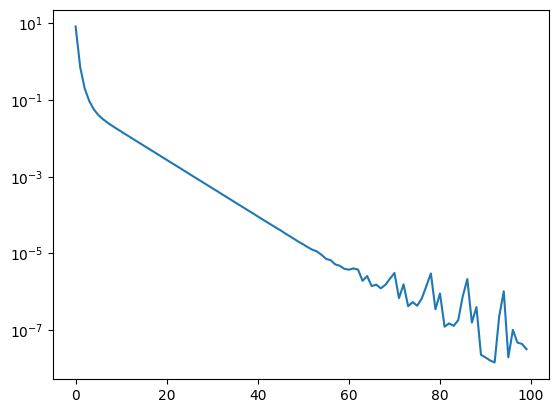

In [65]:
plt.plot(disagreement)
plt.yscale('log')